In [4]:
import pandas as pd
import pydicom
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib
from pathlib import Path
import shutil
import sys
from pathlib import Path
import os

In [5]:
cwd = Path.cwd()
while cwd.stem != "pyplatypus":
    cwd = cwd.parent
os.chdir(cwd)

# Prepare dataset

In [6]:
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [4]:
def prepare_train_val_data(
        raw_data_paths: list[Path],
        csv_path: Path,
        data_path: Path,
        val_train_ratio: float=0.2
):
    training_data_path = data_path + "/siim_training"
    validation_data_path = data_path + "/siim_validation"
    
    Path(training_data_path).mkdir(parents=True, exist_ok=True)
    Path(validation_data_path).mkdir(parents=True, exist_ok=True)
    
    data_df = pd.read_csv(csv_path)
    width, height = 1024, 1024
    not_empty_masks = list()

    for idx, path in enumerate(raw_data_paths):
        file_name = path.split('/')[-1][:-4]
        if all(data_df["ImageId"] != file_name):
            continue
        data_path = validation_data_path if np.random.uniform() <= val_train_ratio else training_data_path
        Path(f"{data_path}/image_{idx}").mkdir(parents=True, exist_ok=True)
        rle_mask = data_df[data_df["ImageId"] == file_name][" EncodedPixels"].values[0]
        if  "-1" in rle_mask:
            mask = np.zeros((width, height))
        else:
            mask = rle2mask(rle_mask, width, height)
            not_empty_masks.append(idx)
        Path(f"{data_path}/image_{idx}/images").mkdir(parents=True, exist_ok=True)
        Path(f"{data_path}/image_{idx}/masks").mkdir(parents=True, exist_ok=True)
        shutil.copyfile(path, f"{data_path}/image_{idx}/images/image_{idx}.dcm")
        matplotlib.image.imsave(f"{data_path}/image_{idx}/masks/mask_{idx}.png", mask)

In [7]:
raw_data_paths = sorted(glob('/home/johnny/Documents/pyplatypus/data/dicom-images-train/*/*/*.dcm'))
data_path = "/home/johnny/Documents/pyplatypus/examples/data"
csv_path = "/home/johnny/Documents/pyplatypus/data/train-rle.csv"
prepare_train_val_data(raw_data_paths, csv_path, data_path)

NameError: name 'prepare_train_val_data' is not defined

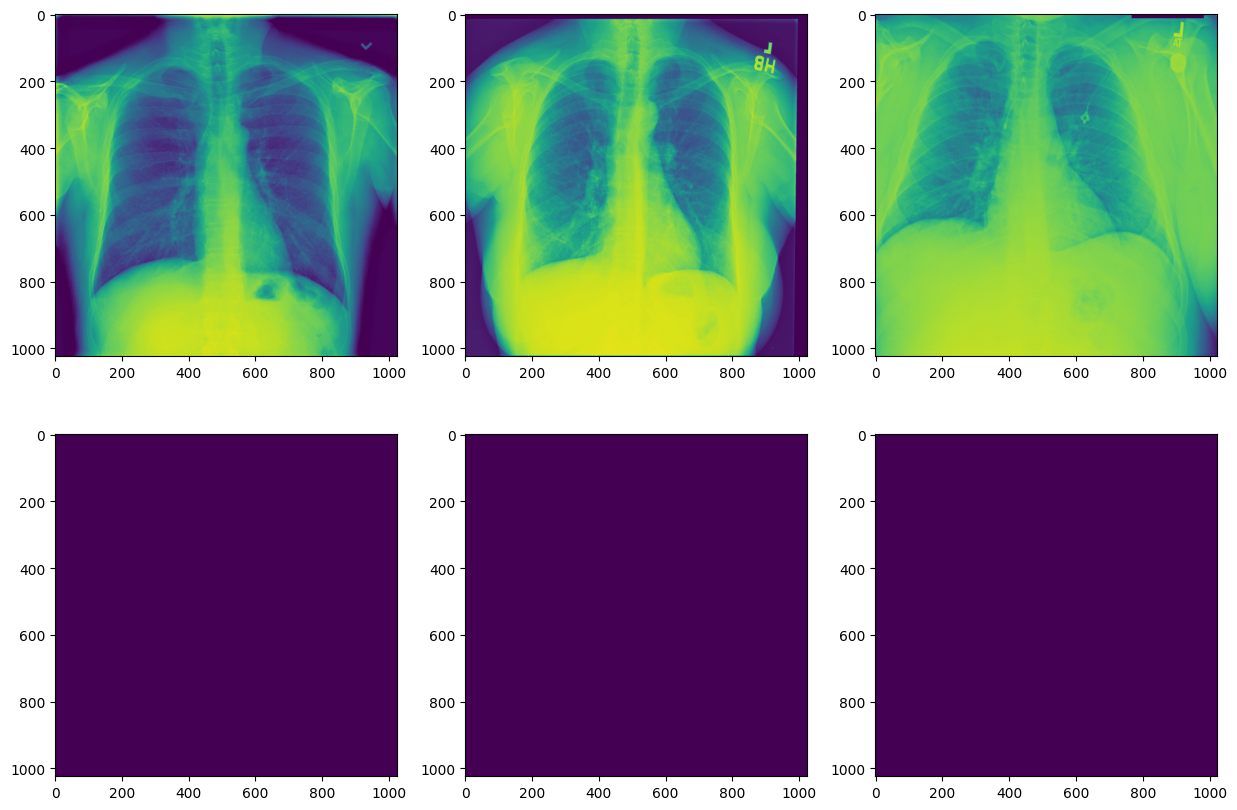

In [8]:
random_imgs_idxs = np.random.choice([i.split("_")[1] for i in os.listdir(data_path + "/siim_training")], 3)
fig, axs = plt.subplots(2, 3, figsize=(15,10))
for idx, random_imgs_idx in enumerate(random_imgs_idxs):
    img_path = data_path + f"/siim_training/image_{random_imgs_idx}/images/image_{random_imgs_idx}.dcm"
    mask_path = data_path + f"/siim_training/image_{random_imgs_idx}/masks/mask_{random_imgs_idx}.png"
    img = pydicom.dcmread(img_path).pixel_array
    mask = plt.imread(mask_path)
    axs[0, idx].imshow(img)
    axs[1, idx].imshow(mask)

# Run training

In [9]:
from pyplatypus.solvers.platypus_cv_solver import PlatypusSolver

ps = PlatypusSolver(
    config_yaml_path=Path("examples/siim_acr.yml")
)
ps.train()

2022-10-24 16:18:10.266191: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-24 16:18:10.358990: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/johnny/.virtualenvs/platypus/lib/python3.9/site-packages/cv2/../../lib64:
2022-10-24 16:18:10.359006: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-24 16:18:10.373360: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when on

8602 images detected!
Set 'steps_per_epoch' to: 269
2073 images detected!
Set 'steps_per_epoch' to: 65


2022-10-24 16:18:11.429388: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-24 16:18:11.429564: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/johnny/.virtualenvs/platypus/lib/python3.9/site-packages/cv2/../../lib64:
2022-10-24 16:18:11.429597: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/johnny/.virtualenvs/platypus/lib/python3.9/site-packages/cv2/../../lib64:
2022-10-24 16:18:11.429626: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libc

In [6]:
metrics = ps.evaluate_models(task_type="semantic_segmentation")

2073 images detected!
Set 'steps_per_epoch' to: 65
65/65 [==============================] - 264s 4s/step - loss: 0.0000e+00 - tversky_coefficient: 4.7889e-14 - iou_coefficient: 4.7889e-14 - categorical_crossentropy: 0.0000e+00
EVALUATION RESULTS:

[  model_name  focal_loss  categorical_crossentropy  iou_coefficient  \
0  res_u_net         0.0              4.788910e-14     4.788910e-14   

   tversky_coefficient  
0                  0.0  ]


In [7]:
for m in metrics:
    print(m)

  model_name  focal_loss  categorical_crossentropy  iou_coefficient  \
0  res_u_net         0.0              4.788910e-14     4.788910e-14   

   tversky_coefficient  
0                  0.0  


In [10]:
# Ive chosen a subset of validation dataset for inference 
images_for_prediction_path = "/home/johnny/Documents/pyplatypus/examples/data/siim_validation_10"
ps.produce_and_save_predicted_masks_for_model(
    model_name="res_u_net",
    custom_data_path=images_for_prediction_path)

9 images detected!
Set 'steps_per_epoch' to: 1
1/1 [==============================] - 1s 740ms/step


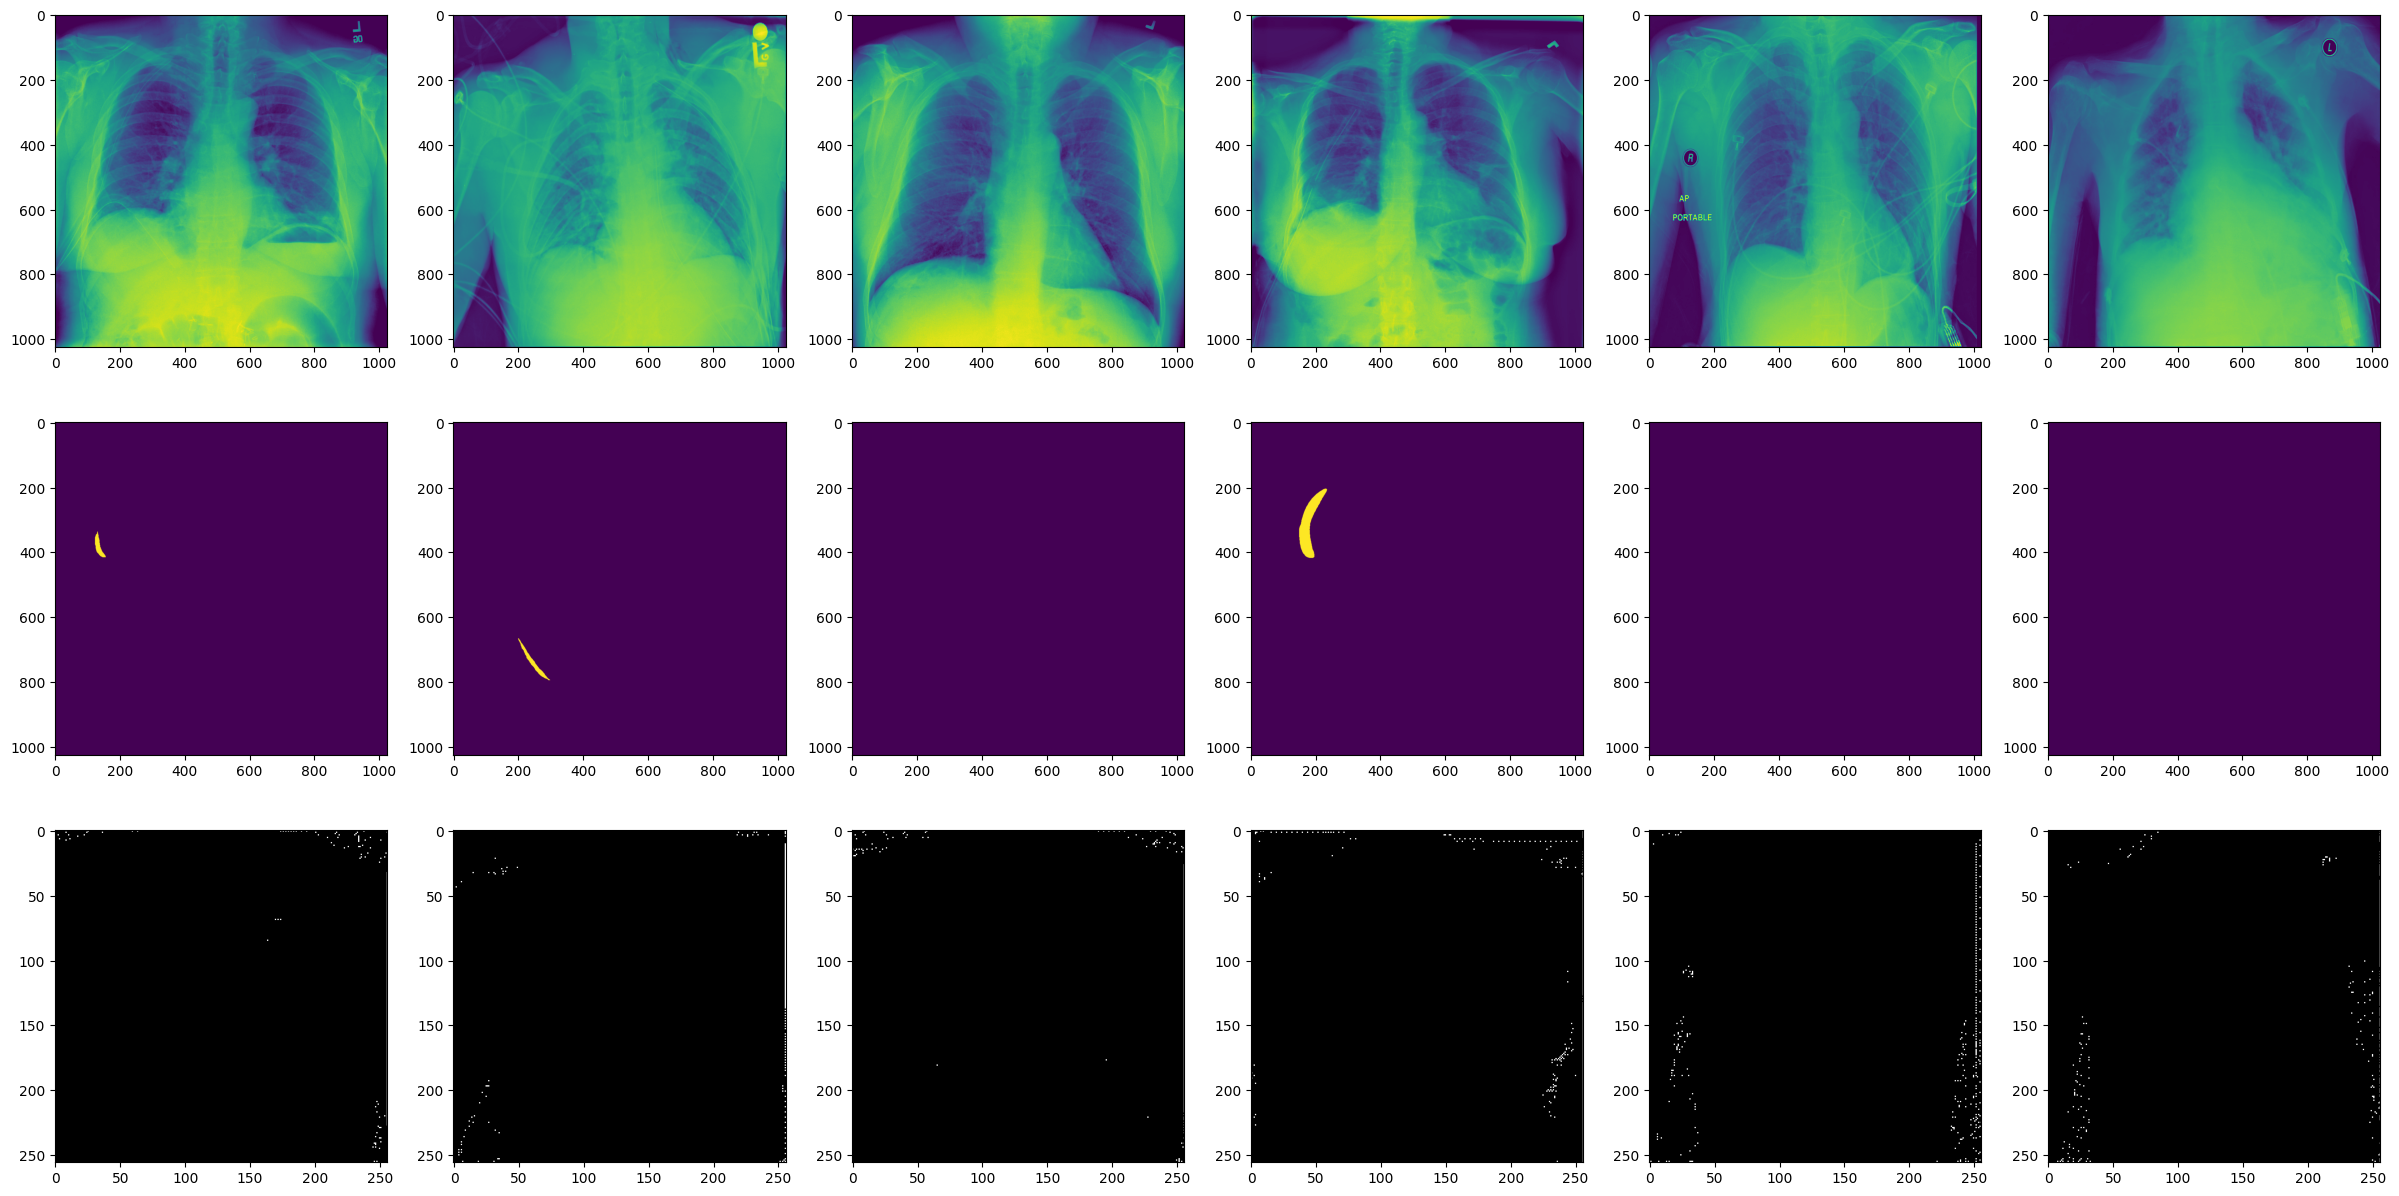

In [41]:
n=6
fig, axs = plt.subplots(3, n, figsize = (30,15))
for idx, file in enumerate(np.random.choice(os.listdir(images_for_prediction_path), n, replace=False)):
        path = os.path.join(images_for_prediction_path, file)
        dcm = pydicom.dcmread(path + "/images/" + file + ".dcm").pixel_array
        gt = plt.imread(path + "/masks/mask_" + file.split("_")[1] + ".png")
        mask = plt.imread(path + "/predicted_masks/" + file + "_res_u_net_predicted_mask.png")
        axs[0, idx].imshow(dcm)
        axs[1, idx].imshow(gt)
        axs[2, idx].imshow(mask)